In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('YearPredictionMSD.txt', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [3]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [4]:
set_random_seed(42)

In [5]:
class RandomDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return {
            "sample": torch.tensor(self.x[idx, :], dtype=torch.float),
            "target": self.y[idx],
        }

In [102]:
from sklearn.preprocessing import StandardScaler

set_random_seed(42)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = np.array(y[:train_size]).reshape(-1, 1)
X_test = X[train_size:, :]
y_test = np.array(y[train_size:]).reshape(-1, 1)

X_train_norm = scaler_X.fit_transform(X_train)
X_test_norm = scaler_X.transform(X_test)
y_train_norm = scaler_y.fit_transform(y_train)

In [103]:
set_random_seed(42)
train_set = RandomDataset(X_train_norm, y_train_norm)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=512, shuffle=True) # 8192 

test_set = RandomDataset(X_test_norm, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512)

model = nn.Sequential(
    nn.Linear(X_train.shape[1], 128), 
    nn.SiLU(),
    nn.Linear(128,256), 
    nn.SiLU(),
    nn.Linear(256,512), 
    nn.SiLU(),
    nn.Dropout(0.2),
    nn.Linear(512,128),
    nn.SiLU(),
    nn.Dropout(0.2),
    nn.Linear(128,32), 
    nn.SiLU(),
    nn.Linear(32,1)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00005)
criterion = nn.MSELoss(reduction= 'mean')

In [104]:
set_random_seed(42)
train_loss_each_epoch = []
test_loss_each_epoch = []
for epoch in range(12):
    train_loss = []
    for batch in tqdm(train_loader): 
        input = batch["sample"]
        answer = batch["target"]
        output = model(input) 
        loss = criterion(output, answer.float())
        output_rev = torch.from_numpy(scaler_y.inverse_transform(output.detach().numpy()))
        answer_rev = torch.from_numpy(scaler_y.inverse_transform(answer))
        train_loss.append(criterion(output_rev, answer_rev))
        loss.backward()
        optimizer.step() 
        optimizer.zero_grad() 
        
    test_loss = [] 
    with torch.no_grad(): 
        for batch in tqdm(test_loader): 
            x_test_batch = batch["sample"]
            y_test_batch = batch["target"]
            y_pred_test = model(x_test_batch)
            y_pred_test_rev = torch.from_numpy(scaler_y.inverse_transform(y_pred_test.detach().numpy()))
            test_loss.append(criterion(y_pred_test_rev, y_test_batch))  

    print(f"Epoch: {epoch}, train_loss: {np.mean(train_loss)**0.5}, test_loss: {np.mean(test_loss)**0.5}")
    train_loss_each_epoch.append(np.mean(train_loss)**0.5)
    test_loss_each_epoch.append(np.mean(test_loss)**0.5)

  0%|          | 0/906 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 0, train_loss: 9.002550982254142, test_loss: 8.910580943955846


  0%|          | 0/906 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 1, train_loss: 8.756511759755771, test_loss: 8.870806065761311


  0%|          | 0/906 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 2, train_loss: 8.682068777761689, test_loss: 8.816679267898333


  0%|          | 0/906 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 3, train_loss: 8.621420318311475, test_loss: 8.852096878176662


  0%|          | 0/906 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 4, train_loss: 8.57483055186553, test_loss: 8.790566711557997


  0%|          | 0/906 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 5, train_loss: 8.527119983518636, test_loss: 8.784259104091392


  0%|          | 0/906 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 6, train_loss: 8.487119889786717, test_loss: 8.776725282088194


  0%|          | 0/906 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 7, train_loss: 8.442059832546242, test_loss: 8.79692226688567


  0%|          | 0/906 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 8, train_loss: 8.405458759295414, test_loss: 8.822785131441542


  0%|          | 0/906 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 9, train_loss: 8.368620906123992, test_loss: 8.774847445561154


  0%|          | 0/906 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 10, train_loss: 8.328860604439601, test_loss: 8.824585763864986


  0%|          | 0/906 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 11, train_loss: 8.290230910203, test_loss: 8.854078967090182


In [105]:
min(test_loss_each_epoch)

8.774847445561154

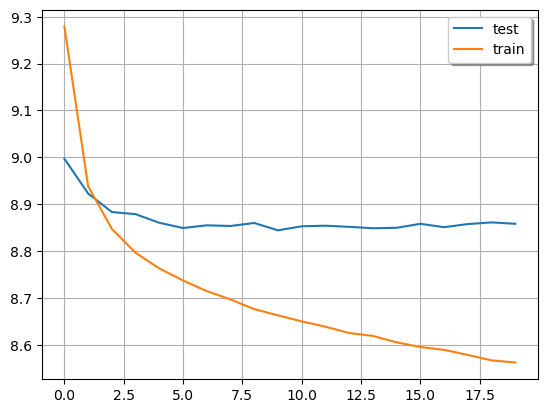

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(range(0, 10), test_loss_each_epoch[:], label='test')
ax.plot(range(0, 10), train_loss_each_epoch[:], label='train')
ax.legend(shadow = True)
ax.grid()
plt.show()